<a href="https://colab.research.google.com/github/abdansykr/analisis-sentimen-transformer-id/blob/master/indoBERT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jalankan sel ini untuk menginstal library yang diperlukan dari Hugging Face, Scikit-learn, dll.
!pip install transformers[torch]
!pip install pandas
!pip install scikit-learn
!pip install numpy
!pip install openpyxl # Diperlukan untuk menyimpan ke format Excel
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Impor komponen penting dari library Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
0
print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


In [ ]:
# --- 1. MEMUAT DAN MENGACAK DATA ---
# Ganti 'ulasan_pasar_stan_jogja.csv' dengan nama file Anda
try:
    df = pd.read_csv('tokopedia_labeled.csv')
except FileNotFoundError:
    print("File data tidak ditemukan. Pastikan file CSV ada di direktori yang sama atau jalankan sel simulasi data di atas.")
    # Hentikan eksekusi jika file tidak ada
    # Anda bisa menambahkan exit() jika ini adalah script .py

# Pengacakan (Shuffling)
# frac=1 berarti mengambil 100% data (semua baris) secara acak
df = df.sample(frac=1).reset_index(drop=True)
print("Data berhasil dimuat dan diacak.")
print("Total data:", len(df))

# --- 2. PEMBAGIAN PROPORSI DATA (80:10:10) ---
# Pertama, pisahkan data latih (80%) dari sisa data (20%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['cleaned_text'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment']
)

# Kedua, bagi sisa data (20%) menjadi dua, untuk validasi (10%) dan uji (10%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"\nUkuran Data Latih (Training Set): {len(train_texts)} ulasan (80%)")
print(f"Ukuran Data Validasi (Validation Set): {len(val_texts)} ulasan (10%)")
print(f"Ukuran Data Uji (Test Set): {len(test_texts)} ulasan (10%)")

Data berhasil dimuat dan diacak.
Total data: 15278

Ukuran Data Latih (Training Set): 12222 ulasan (80%)
Ukuran Data Validasi (Validation Set): 1528 ulasan (10%)
Ukuran Data Uji (Test Set): 1528 ulasan (10%)


In [ ]:
# --- (OPSIONAL) MENYIMPAN HASIL PEMBAGIAN DATA KE FILE ---

# Gabungkan teks dan label menjadi DataFrame untuk setiap set
df_train = pd.DataFrame({'cleaned_text': train_texts, 'sentiment': train_labels})
df_val = pd.DataFrame({'cleaned_text': val_texts, 'sentiment': val_labels})
df_test = pd.DataFrame({'cleaned_text': test_texts, 'sentiment': test_labels})

# Simpan ke file CSV
df_train.to_csv('data_latih.csv', index=False)
df_val.to_csv('data_validasi.csv', index=False)
df_test.to_csv('data_uji.csv', index=False)

print("\n(Opsional) Data latih, validasi, dan uji telah disimpan ke file terpisah.")


(Opsional) Data latih, validasi, dan uji telah disimpan ke file terpisah.


In [ ]:
# --- 3. TOKENISASI ---
# Tentukan model pre-trained yang akan digunakan
MODEL_NAME = 'indobenchmark/indobert-base-p1'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Fungsi untuk melakukan tokenisasi pada data teks
def tokenize_data(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length', # Tambah padding agar semua sekuens sama panjang
        truncation=True,      # Potong sekuens jika lebih panjang dari max_length
        max_length=128,       # Panjang maksimal sekuens (bisa disesuaikan)
        return_tensors='pt'   # Kembalikan sebagai PyTorch Tensors
    )

# Lakukan tokenisasi pada setiap set data
train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)
test_encodings = tokenize_data(test_texts)

print("Contoh hasil tokenisasi untuk ulasan pertama di data latih:")
print("Teks Asli:", train_texts.iloc[0])
print("Token IDs:", train_encodings['input_ids'][0])
print("Attention Mask:", train_encodings['attention_mask'][0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Contoh hasil tokenisasi untuk ulasan pertama di data latih:
Teks Asli: tokonya amanah .terimakasih barang sesuai
Token IDs: tensor([    2,  1605,    57, 10651, 30470,  5196,   963,   786,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    

In [ ]:
# Sel ini dijalankan SETELAH sel tokenisasi Anda

# Ambil sampel pertama dari data latih untuk didemonstrasikan
sampel_indeks = 0
teks_asli = train_texts.iloc[sampel_indeks]
input_ids = train_encodings['input_ids'][sampel_indeks]
attention_mask = train_encodings['attention_mask'][sampel_indeks]

# Ubah kembali Token ID menjadi token string yang bisa dibaca manusia
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Buat DataFrame untuk presentasi yang rapi
import pandas as pd
df_tokenisasi = pd.DataFrame({
    'Token': tokens,
    'Token ID': input_ids.numpy(),      # Konversi tensor ke numpy array
    'Attention Mask': attention_mask.numpy()
})

# --- TAMPILKAN OUTPUT YANG SUDAH DIRAPIKAN ---

print("=" * 80)
print("HASIL PROSES TOKENISASI (SAMPEL PERTAMA DARI DATA LATIH)")
print("=" * 80)
print(f"\n[Teks Asli]\n'{teks_asli}'")
print("\n" + "-" * 50)

# Tampilkan dalam bentuk tabel yang detail
print("\n[Visualisasi Tabel Hasil Tokenisasi]\n")
# Gunakan to_string() agar semua baris (128) ditampilkan
print(df_tokenisasi.to_string())
print("\n" + "=" * 80)

HASIL PROSES TOKENISASI (SAMPEL PERTAMA DARI DATA LATIH)

[Teks Asli]
'tokonya amanah .terimakasih barang sesuai'

--------------------------------------------------

[Visualisasi Tabel Hasil Tokenisasi]

           Token  Token ID  Attention Mask
0          [CLS]         2               1
1           toko      1605               1
2          ##nya        57               1
3         amanah     10651               1
4              .     30470               1
5    terimakasih      5196               1
6         barang       963               1
7         sesuai       786               1
8          [SEP]         3               1
9          [PAD]         0               0
10         [PAD]         0               0
11         [PAD]         0               0
12         [PAD]         0               0
13         [PAD]         0               0
14         [PAD]         0               0
15         [PAD]         0               0
16         [PAD]         0               0
17         [PAD]     

In [ ]:
# Membuat mapping dari label string ke integer
label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
# Membuat mapping sebaliknya untuk interpretasi hasil
inv_label_map = {v: k for k, v in label_map.items()}

# Konversi label string ke integer
train_labels_int = torch.tensor(train_labels.map(label_map).tolist())
val_labels_int = torch.tensor(val_labels.map(label_map).tolist())
test_labels_int = torch.tensor(test_labels.map(label_map).tolist())

# Membuat objek Dataset PyTorch
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_int)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels_int)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_int)

print("\nData siap untuk dimasukkan ke model.")


Data siap untuk dimasukkan ke model.


In [ ]:
# --- 4. DEFINISI DAN PELATIHAN MODEL ---

# Tentukan device (menggunakan GPU jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# Muat model untuk klasifikasi sekuens dengan 3 label
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_map) # 3 kelas: positif, negatif, netral
).to(device)

# Buat DataLoader untuk memproses data dalam batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Tentukan optimizer (AdamW adalah standar untuk Transformer)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Tentukan jumlah epoch (siklus pelatihan)
num_epochs = 5 # Untuk skripsi, 3-5 epoch adalah awal yang baik
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# --- Kode Pelatihan yang Disempurnakan ---

# Siapkan list untuk menyimpan riwayat pelatihan
training_history = []

# Loop Pelatihan
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")

    # --- Tahap Pelatihan (Training) ---
    model.train()
    total_train_loss = 0
    total_train_correct = 0 # TAMBAHAN: untuk menghitung akurasi latih

    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Kalkulasi untuk loss
        total_train_loss += loss.item()

        # --- BLOK TAMBAHAN: Kalkulasi untuk akurasi latih ---
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        total_train_correct += (predictions == labels).sum().item()
        # --- AKHIR BLOK TAMBAHAN ---

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    # Hitung rata-rata loss dan akurasi latih
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / len(train_dataset)
    print(f"Rata-rata Loss Pelatihan: {avg_train_loss:.4f}")
    print(f"Akurasi Pelatihan: {train_accuracy:.4f}")

    # --- Tahap Validasi ---
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            total_val_correct += (predictions == labels).sum().item()

    # Hitung rata-rata loss dan akurasi validasi
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / len(val_dataset)
    print(f"Rata-rata Loss Validasi: {avg_val_loss:.4f}")
    print(f"Akurasi Validasi: {val_accuracy:.4f}")

    # Simpan hasil epoch ini ke dalam riwayat
    training_history.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': avg_val_loss,
        'val_accuracy': val_accuracy
    })

print("\nPelatihan selesai!")

Menggunakan device: cuda


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Rata-rata Loss Pelatihan: 0.3188
Akurasi Pelatihan: 0.8783
Rata-rata Loss Validasi: 0.1684
Akurasi Validasi: 0.9418

--- Epoch 2/5 ---
Rata-rata Loss Pelatihan: 0.1347
Akurasi Pelatihan: 0.9551
Rata-rata Loss Validasi: 0.1517
Akurasi Validasi: 0.9529

--- Epoch 3/5 ---
Rata-rata Loss Pelatihan: 0.0868
Akurasi Pelatihan: 0.9709
Rata-rata Loss Validasi: 0.1369
Akurasi Validasi: 0.9568

--- Epoch 4/5 ---
Rata-rata Loss Pelatihan: 0.0505
Akurasi Pelatihan: 0.9842
Rata-rata Loss Validasi: 0.1385
Akurasi Validasi: 0.9594

--- Epoch 5/5 ---
Rata-rata Loss Pelatihan: 0.0268
Akurasi Pelatihan: 0.9913
Rata-rata Loss Validasi: 0.1420
Akurasi Validasi: 0.9594

Pelatihan selesai!


In [ ]:
# Konversi riwayat pelatihan menjadi DataFrame Pandas
df_history = pd.DataFrame(training_history)

# Atur 'epoch' sebagai indeks untuk tampilan yang lebih baik
df_history = df_history.set_index('epoch')

print("--- Ringkasan Hasil Pelatihan Model ---")
# Tampilkan tabel
display(df_history)

--- Ringkasan Hasil Pelatihan Model ---


,train_loss,train_accuracy,val_loss,val_accuracy
epoch,,,,
1,0.318751,0.878252,0.168411,0.941754
2,0.134671,0.955081,0.151655,0.952880
3,0.086810,0.970872,0.136873,0.956806
4,0.050537,0.984209,0.138500,0.959424
5,0.026843,0.991327,0.141975,0.959424


In [ ]:
# --- 5. EVALUASI PADA DATA UJI ---
model.eval()
all_preds = []
all_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Dapatkan prediksi dengan mengambil indeks probabilitas tertinggi
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Konversi prediksi dan label dari integer kembali ke string untuk analisis
predicted_labels = [inv_label_map[p] for p in all_preds]
true_labels_str = [inv_label_map[t] for t in all_true_labels]

print("Evaluasi pada 100 ulasan Data Uji selesai.")

Evaluasi pada 100 ulasan Data Uji selesai.


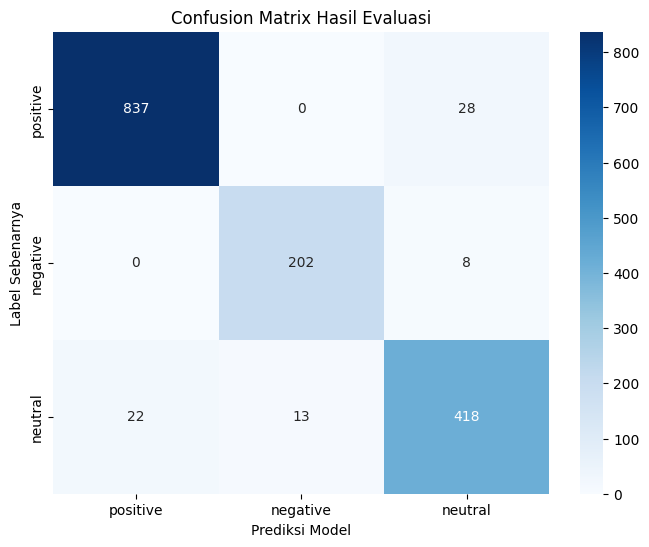


Laporan Klasifikasi Lengkap:

              precision    recall  f1-score   support

    positive       0.94      0.96      0.95       210
    negative       0.92      0.92      0.92       453
     neutral       0.97      0.97      0.97       865

    accuracy                           0.95      1528
   macro avg       0.94      0.95      0.95      1528
weighted avg       0.95      0.95      0.95      1528

Akurasi Keseluruhan (Overall Accuracy): 95.35%
Interpretasi: Secara keseluruhan, model mampu mengklasifikasikan sentimen dengan benar pada 95.35% data uji.

--- Analisis Detail untuk Kelas 'Positif' ---
Precision: 0.974 ($Precision = TP / (TP + FP)$)
Recall:    0.968 ($Recall = TP / (TP + FN)$)
F1-Score:  0.971 ($F1-Score = 2 * (Precision * Recall) / (Precision + Recall)$)


In [ ]:
# --- 6. ANALISIS HASIL DAN METRIK EVALUASI ---

# A. Confusion Matrix
# Menghitung confusion matrix menggunakan scikit-learn
labels = list(label_map.keys())
cm = confusion_matrix(true_labels_str, predicted_labels, labels=labels)

# Visualisasi Confusion Matrix menggunakan Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix Hasil Evaluasi')
plt.show()

# B. Laporan Klasifikasi (Precision, Recall, F1-Score)
print("\nLaporan Klasifikasi Lengkap:\n")
print(classification_report(true_labels_str, predicted_labels, target_names=labels))

# C. Akurasi Keseluruhan
accuracy = accuracy_score(true_labels_str, predicted_labels)
print(f"Akurasi Keseluruhan (Overall Accuracy): {accuracy*100:.2f}%")
print(f"Interpretasi: Secara keseluruhan, model mampu mengklasifikasikan sentimen dengan benar pada {accuracy*100:.2f}% data uji.")

# D. Perhitungan Manual untuk Kelas "Positif" (seperti contoh Anda)
# TP = cm[0, 0]
# FP = cm[1, 0] + cm[2, 0]
# FN = cm[0, 1] + cm[0, 2]
# Catatan: Perhitungan FP/FN dari confusion matrix sklearn sedikit berbeda
# FP untuk 'positif' adalah jumlah prediksi 'positif' pada label asli lainnya.
# FN untuk 'positif' adalah jumlah prediksi lain pada label asli 'positif'.
tp_pos = cm[0, 0]
fp_pos = cm[1, 0] + cm[2, 0]
fn_pos = cm[0, 1] + cm[0, 2]

# Precision untuk kelas "Positif"
precision_pos = tp_pos / (tp_pos + fp_pos) if (tp_pos + fp_pos) > 0 else 0
# Recall untuk kelas "Positif"
recall_pos = tp_pos / (tp_pos + fn_pos) if (tp_pos + fn_pos) > 0 else 0
# F1-Score untuk kelas "Positif"
f1_pos = 2 * (precision_pos * recall_pos) / (precision_pos + recall_pos) if (precision_pos + recall_pos) > 0 else 0

print("\n--- Analisis Detail untuk Kelas 'Positif' ---")
print(f"Precision: {precision_pos:.3f} ($Precision = TP / (TP + FP)$)")
print(f"Recall:    {recall_pos:.3f} ($Recall = TP / (TP + FN)$)")
print(f"F1-Score:  {f1_pos:.3f} ($F1-Score = 2 * (Precision * Recall) / (Precision + Recall)$)")

In [ ]:
# --- 7. EKSPOR HASIL PREDIKSI ---

# Buat DataFrame dari hasil evaluasi pada data uji
results_df = pd.DataFrame({
    'Ulasan': test_texts,
    'Sentimen Sebenarnya': true_labels_str,
    'Prediksi Model': predicted_labels
})

# Simpan ke file Excel
nama_file_hasil = 'hasil_analisis_sentimen.xlsx'
results_df.to_excel(nama_file_hasil, index=False)

print(f"\nHasil analisis pada data uji telah diekspor ke file '{nama_file_hasil}'.")
print(results_df.head(10))


Hasil analisis pada data uji telah diekspor ke file 'hasil_analisis_sentimen.xlsx'.
                                                  Ulasan Sentimen Sebenarnya  \
12012                                      cepat sampai             positive   
3471                                          kemas rapi             neutral   
12568      produk tidak terkirim, tapi dana dikembalikan            negative   
7850         barang sesuai cuma ada 1 buah rusak terbuka             neutral   
9093                         kualitas baik, kirim cepat.             neutral   
503           minyak goreng sunco bagus untuk menggoreng            positive   
9694                                    sangat memuaskan            positive   
7952         ubi ungu yang dikirim jelek dan busuk semua            negative   
6018                                                  😍😍             neutral   
7161   kirim cepat barang mendarat dengan mulus dan b...            positive   

      Prediksi Model  
12012      

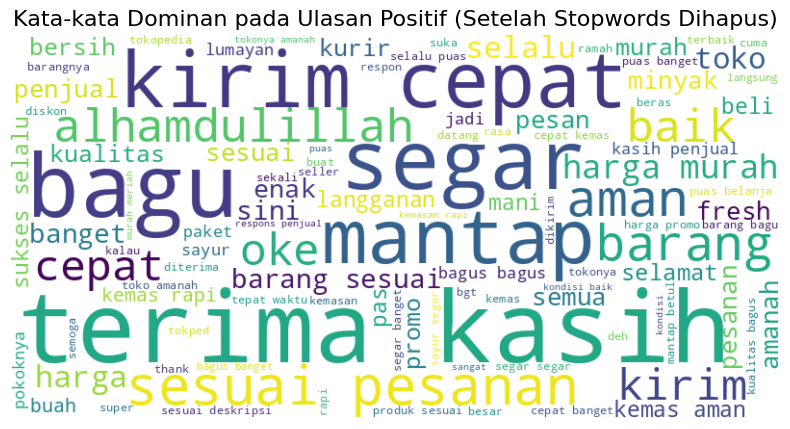

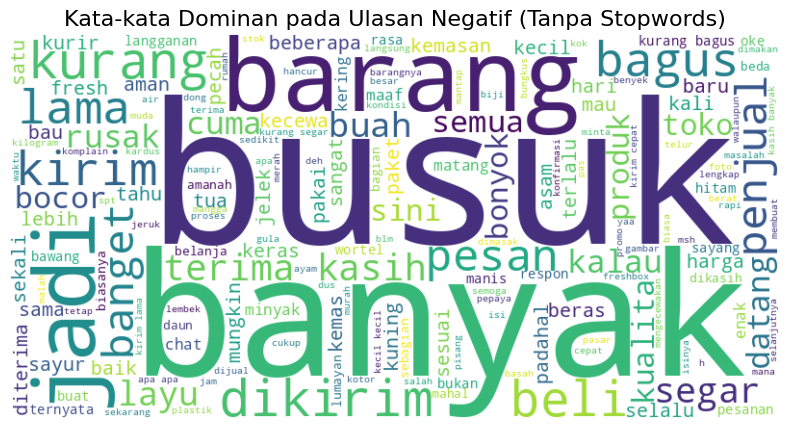

In [ ]:
!pip install Sastrawi

from wordcloud import WordCloud, STOPWORDS
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# --- BUAT DAFTAR STOPWORDS ---
factory = StopWordRemoverFactory()
sastrawi_stopwords = factory.get_stop_words()
# Tambahkan stopwords lain yang sering muncul tapi tidak relevan
additional_stopwords = {'dan', 'yg', 'ga', 'gak', 'nya', 'di', 'ke', 'ini', 'itu', 'sih', 'ya', 'jg', 'juga'}

# Gabungkan semua stopwords
stopwords_indonesia = set(sastrawi_stopwords).union(additional_stopwords)


# --- KODE UNTUK MEMBUAT WORD CLOUD YANG LEBIH BERSIH ---

def buat_wordcloud_bersih(teks, judul):
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          stopwords=stopwords_indonesia, # <-- Gunakan parameter stopwords
                          colormap='viridis',
                          min_font_size=10).generate(teks)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(judul, fontsize=16)
    plt.show()

# Panggil fungsi yang baru
# (pastikan variabel teks_positif sudah ada)
buat_wordcloud_bersih(teks_positif, 'Kata-kata Dominan pada Ulasan Positif (Setelah Stopwords Dihapus)')
buat_wordcloud_bersih(teks_negatif, 'Kata-kata Dominan pada Ulasan Negatif (Tanpa Stopwords)')


Data hasil evaluasi dari 'tokopedia_labeled.csv' berhasil dimuat.

--- Word Cloud untuk Ulasan Positif ---


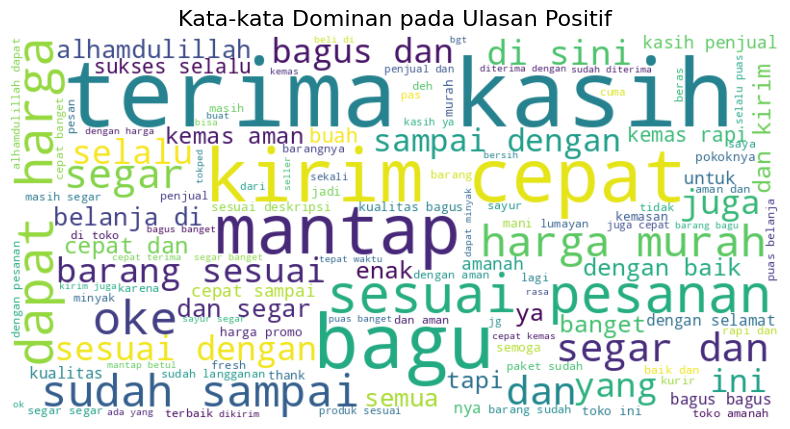


--- Word Cloud untuk Ulasan Negatif ---


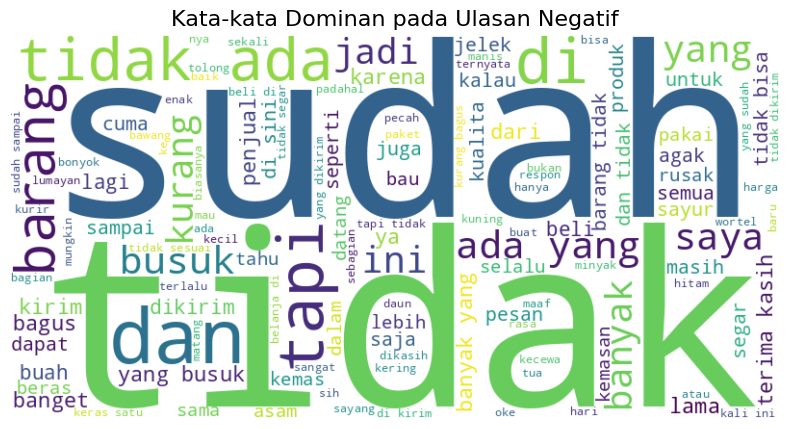

In [ ]:
# Jalankan ini jika Anda belum memiliki library wordcloud
!pip install wordcloud

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- 1. MUAT DATA HASIL EVALUASI ---
# Nama file sekarang adalah file CSV
file_hasil = 'tokopedia_labeled.csv'

# >>> PERUBAHAN DI SINI: Gunakan pd.read_csv() bukan pd.read_excel() <<<
df_hasil = pd.read_csv(file_hasil)

print(f"Data hasil evaluasi dari '{file_hasil}' berhasil dimuat.")

# --- 2. PISAHKAN ULASAN BERDASARKAN SENTIMEN PREDIKSI ---

# Ganti 'Prediksi Model' dengan nama kolom sentimen/prediksi Anda yang sebenarnya jika berbeda
# Misalnya, jika nama kolomnya adalah 'sentiment'
kolom_sentimen = 'sentiment'

ulasan_positif = df_hasil[df_hasil[kolom_sentimen] == 'positive']
ulasan_negatif = df_hasil[df_hasil[kolom_sentimen] == 'negative']

# --- 3. GABUNGKAN SEMUA TEKS DARI SETIAP KATEGORI ---

# Disarankan menggunakan kolom 'cleaned_text' untuk hasil word cloud yang lebih bersih
# Jika tidak ada, 'Ulasan' juga bisa digunakan.
kolom_teks = 'cleaned_text'

teks_positif = ' '.join(ulasan_positif[kolom_teks].astype(str))
teks_negatif = ' '.join(ulasan_negatif[kolom_teks].astype(str))


# --- 4. BUAT DAN TAMPILKAN WORD CLOUD ---

def buat_wordcloud(teks, judul):
    """Fungsi untuk membuat dan menampilkan word cloud."""
    # Menambahkan pengecekan jika teks kosong untuk menghindari error
    if not teks.strip():
        print(f"Tidak ada kata untuk dibuat Word Cloud pada: {judul}")
        return

    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          colormap='viridis',
                          min_font_size=10).generate(teks)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(judul, fontsize=16)
    plt.show()

# Membuat Word Cloud untuk ulasan Positif
print("\n--- Word Cloud untuk Ulasan Positif ---")
buat_wordcloud(teks_positif, 'Kata-kata Dominan pada Ulasan Positif')

# Membuat Word Cloud untuk ulasan Negatif
print("\n--- Word Cloud untuk Ulasan Negatif ---")
buat_wordcloud(teks_negatif, 'Kata-kata Dominan pada Ulasan Negatif')

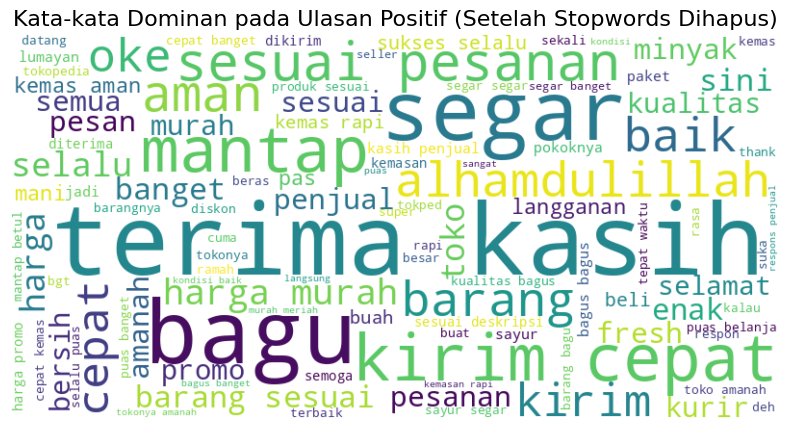

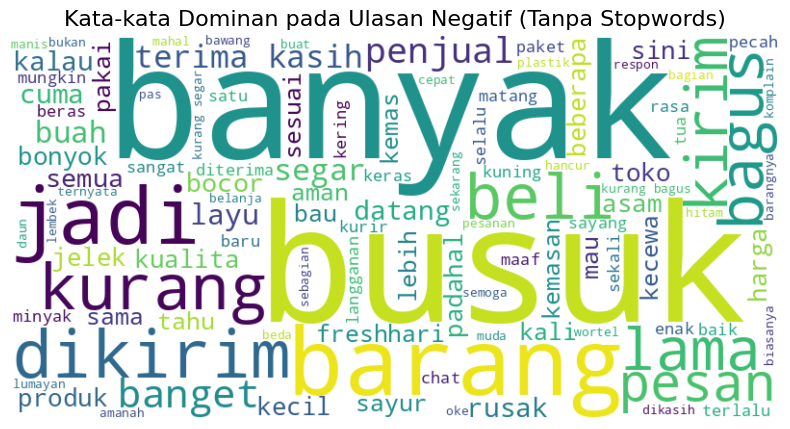

In [ ]:
!pip install Sastrawi

from wordcloud import WordCloud, STOPWORDS
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# --- BUAT DAFTAR STOPWORDS ---
factory = StopWordRemoverFactory()
sastrawi_stopwords = factory.get_stop_words()
# Tambahkan stopwords lain yang sering muncul tapi tidak relevan
additional_stopwords = {'dan', 'yg', 'ga', 'gak', 'nya', 'di', 'ke', 'ini', 'itu', 'sih', 'ya', 'jg', 'juga'}

# Gabungkan semua stopwords
stopwords_indonesia = set(sastrawi_stopwords).union(additional_stopwords)


# --- KODE UNTUK MEMBUAT WORD CLOUD YANG LEBIH BERSIH ---

def buat_wordcloud_bersih(teks, judul):
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          stopwords=stopwords_indonesia, # <-- Gunakan parameter stopwords
                          colormap='viridis',
                          min_font_size=10).generate(teks)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(judul, fontsize=16)
    plt.show()

# Panggil fungsi yang baru
# (pastikan variabel teks_positif sudah ada)
buat_wordcloud_bersih(teks_positif, 'Kata-kata Dominan pada Ulasan Positif (Setelah Stopwords Dihapus)')
print("")
buat_wordcloud_bersih(teks_negatif, 'Kata-kata Dominan pada Ulasan Negatif (Tanpa Stopwords)')
